In [1]:
# Import necessary libraries
import requests
import pandas as pd
import json
import time
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
from Data.db import Database
db = Database()

# Define base URL for Alpha Vantage API
ALPHA_VANTAGE_BASE_URL = 'https://www.alphavantage.co/query'
API_KEY = '16U80X1YA3JPOSSY'  # Consider moving this to environment variables

# Function to fetch news from Alpha Vantage API
def fetch_news(ticker=None, topics=None, days_offset=0, chunk_size=30):
    """
    Fetch news articles from Alpha Vantage NEWS_SENTIMENT endpoint
    
    Args:
        ticker (str): Stock ticker symbol to filter news by
        topics (str): Topic to filter news by
        days_offset (int): Days offset from current date
        chunk_size (int): Size of each chunk in days (typically 30 for monthly)
        
    Returns:
        dict: API response containing news items and sentiment data
    """
    # Calculate date range based on offset
    now = datetime.now()
    
    # End date is now minus the offset
    end_date = now - timedelta(days=days_offset)
    
    # Start date is end_date minus the chunk size
    start_date = end_date - timedelta(days=chunk_size)
    
    # Format dates as required by Alpha Vantage (YYYYMMDDTHHMM)
    from_date = start_date.strftime('%Y%m%dT0000')
    to_date = end_date.strftime('%Y%m%dT0000')
    
    print(f"Fetching news from {from_date} to {to_date}")
    
    # Parameters for API request
    params = {
        'function': 'NEWS_SENTIMENT',
        'time_from': from_date,  # Use our calculated dates instead of hardcoded values
        'time_to': to_date,
        'limit': 1000,  # Maximum number of news items to retrieve
        'apikey': API_KEY,
    }
    
    # Add optional parameters if provided
    if ticker:
        params['tickers'] = ticker
    if topics:
        params['topics'] = topics
    
    try:
        response = requests.get(ALPHA_VANTAGE_BASE_URL, params=params)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        result = response.json()
        return result
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching news: {e}")
        return {"feed": []}

# Function to store articles in the database
def store_articles_in_db(news_data):
    """
    Store list of articles from Alpha Vantage API in the database
    Args:
        news_data (dict): News data from Alpha Vantage API
    Returns:
        int: Number of articles stored
    """
    stored_count = 0
    
    if not news_data or "feed" not in news_data:
        print("No news feed data found in the response")
        return 0
    
    for article in news_data["feed"]:
        try:
            # Convert authors list to string
            authors = ", ".join(article.get('authors', [])) if article.get('authors') else ""
            
            # Convert topics list to JSON string
            topics = json.dumps(article.get('topics', []))
            
            # Convert ticker sentiment to JSON string
            ticker_sentiment = json.dumps(article.get('ticker_sentiment', []))
            
            # Extract time published and format if needed
            time_published = article.get('time_published', '')
            # Convert YYYYMMDDTHHMMSS to standard format if needed
            if time_published and len(time_published) >= 8:
                try:
                    dt = datetime.strptime(time_published, '%Y%m%dT%H%M%S')
                    time_published = dt.isoformat()
                except ValueError:
                    # Keep original format if parsing fails
                    pass
            
            # Store the article in the database
            db.store_live_news_articles(
                date=time_published,
                authors=authors,
                source_domain=article.get('source_domain', ''),
                source_name=article.get('source', ''),
                title=article.get('title', ''),
                summary=article.get('summary', ''),
                url=article.get('url', ''),
                topics=topics,
                ticker_sentiment=ticker_sentiment,
                overall_sentiment_label=article.get('overall_sentiment_label', ''),
                overall_sentiment_score=article.get('overall_sentiment_score', 0.0),
                event_type='',  # This field is not in the Alpha Vantage response
                sentiment_label='',  # This is covered by overall_sentiment_label
                sentiment_score=0.0,  # This is covered by overall_sentiment_score
                fetch_timestamp=datetime.now().isoformat()
            )
            
            stored_count += 1
            
        except Exception as e:
            print(f"Error storing article: {e}")
            print(f"Article data: {article}")
    
    return stored_count

# Function to check for duplicate articles
def is_duplicate_article(url, title):
    """
    Check if an article with the same URL or very similar title already exists in the database
    
    Args:
        url (str): URL of the article
        title (str): Title of the article
        
    Returns:
        bool: True if article is a duplicate, False otherwise
    """
    # This is a placeholder function - you would need to implement the actual check
    # by querying your database for existing articles with the same URL or title
    return False

# Function to fetch and save news for multiple tickers or topics
def fetch_and_save_news_monthly(tickers=None, topics=None, starting_month=0, months_back=12):
    """
    Fetch news for multiple tickers or topics in monthly chunks and save to database
    
    Args:
        tickers (list): List of ticker symbols
        topics (list): List of topics
        starting_month (int): Starting point for fetching news (in days)
        months_back (int): Number of months back to search
    """
    total_stored = 0
    
    # Convert months to days (approximate)
    days_back = months_back * 30
    starting_day = starting_month * 30
    # Fetch data in 30-day (monthly) chunks
    for month_chunk in range(starting_day, days_back, 30):
        print(f"\n======= Fetching month {month_chunk // 30 + 1} of {months_back} =======")
        
        # Process tickers if provided
        if tickers:
            for ticker in tickers:
                print(f"Fetching news for ticker {ticker}...")
                ticker_news = fetch_news(ticker=ticker, days_offset=month_chunk, chunk_size=30)
                
                if ticker_news and "feed" in ticker_news and ticker_news["feed"]:
                    # Store articles in database
                    stored_count = store_articles_in_db(ticker_news)
                    total_stored += stored_count
                    print(f"Saved {stored_count} articles to database for ticker {ticker}")
                else:
                    print(f"No articles found for ticker {ticker}")
                
                # Respect API rate limits
                time.sleep(12)  # Alpha Vantage has limits of 5 requests per minute for free API keys
        
        # Process topics if provided
        if topics:
            for topic in topics:
                print(f"Fetching news for topic {topic}...")
                topic_news = fetch_news(topics=topic, days_offset=month_chunk, chunk_size=30)
                
                if topic_news and "feed" in topic_news and topic_news["feed"]:
                    # Store articles in database
                    stored_count = store_articles_in_db(topic_news)
                    total_stored += stored_count
                    print(f"Saved {stored_count} articles to database for topic {topic}")
                else:
                    print(f"No articles found for topic {topic}")
                
                # Respect API rate limits
                time.sleep(12)
    
    print(f"### News fetching and storage completed. Total articles stored: {total_stored} ###")

# Function to parse the Alpha Vantage response and print summary stats
def print_news_summary(news_data):
    """
    Print summary statistics of the news data retrieved
    
    Args:
        news_data (dict): News data from Alpha Vantage API
    """
    if not news_data or "feed" not in news_data:
        print("No news data found")
        return
    
    num_items = len(news_data.get("feed", []))
    print(f"Retrieved {num_items} news items")
    
    # Count by source
    sources = {}
    for item in news_data.get("feed", []):
        source = item.get("source", "Unknown")
        sources[source] = sources.get(source, 0) + 1
    
    print("\nSources breakdown:")
    for source, count in sources.items():
        print(f"- {source}: {count} articles")
    
    # Sentiment distribution
    sentiment_counts = {
        "Bullish": 0,
        "Somewhat_Bullish": 0,
        "Neutral": 0,
        "Somewhat-Bearish": 0,
        "Bearish": 0
    }
    
    for item in news_data.get("feed", []):
        sentiment = item.get("overall_sentiment_label", "Unknown")
        if sentiment in sentiment_counts:
            sentiment_counts[sentiment] += 1
    
    print("\nSentiment distribution:")
    for sentiment, count in sentiment_counts.items():
        print(f"- {sentiment}: {count} articles")

# Example usage
if __name__ == "__main__":
    # Define tickers and topics to track
    target_tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOGL', 'CRYPTO:BTC']
    target_topics = ['Economy', 'Technology', 'Finance']
    
    # Fetch and save news
    fetch_and_save_news_monthly(tickers=['AAPL'], topics=None, starting_month=21, months_back=36)
    
    # Example: fetch and print summary for Bitcoin news
    # btc_news = fetch_news(ticker='CRYPTO:BTC', days_back=7)
    # print_news_summary(btc_news)

ModuleNotFoundError: No module named 'Data'

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from datetime import datetime, timedelta
import os
import re
import IPython.display as display
from tqdm.notebook import tqdm

# Import Database class from db.py in the Data folder
from Data.db import Database

# Create an instance of the Database class
db = Database()

# Set pandas display options
pd.set_option('display.max_colwidth', 100)

# Function to load data from database
def load_data_from_db():
    """
    Load data from SQLite database
    
    Returns:
        pd.DataFrame: DataFrame with loaded data
    """
    try:
        # Get all news articles from the database
        articles = db.get_live_news_articles()
        # Convert to DataFrame
        df = pd.DataFrame(articles)
        print(f"Loaded {len(df)} records from database")
        
        # Convert date columns to datetime
        # for col in ['Date', 'Fetch_Timestamp']:
        #     if col in df.columns:
        #         df[col] = pd.to_datetime(df[col])
        # df = pd.to_datetime(df['Date'], errors='coerce')
        return df
                
    except Exception as e:
        print(f"Error loading data from database: {e}")
        return pd.DataFrame()

# Setup for sentiment analysis with FinBERT
def setup_finbert():
    """
    Setup FinBERT model for sentiment analysis
    
    Returns:
        tuple: (tokenizer, model)
    """
    # Load the FinBERT tokenizer and model
    # Using the financial-bert model fine-tuned for sentiment analysis
    model_name = "ProsusAI/finbert"
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        # Move model to GPU if available
        if torch.cuda.is_available():
            device = torch.device("cuda")  # NVIDIA GPU
            print("Using NVIDIA GPU.")
        else:
            device = torch.device("cpu")  # Otherwise, back to CPU
            print("Using CPU.")
        model = model.to(device)
        return tokenizer, model
    except Exception as e:
        print(f"Error loading RoBERTa model: {e}")
        return None, None

# Function to analyze sentiment with FinBERT
def analyze_sentiment_finbert(text, tokenizer, model, max_length=512):
    """
    Analyze sentiment of text using FinBERT
    
    Args:
        text (str): Text to analyze
        tokenizer: FinBERT tokenizer
        model: FinBERT model
        max_length (int): Maximum token length
        
    Returns:
        tuple: (sentiment_label, sentiment_score)
    """
    if not text or not isinstance(text, str) or not tokenizer or not model:
        return "neutral", 0.0
    
    # Truncate text if needed
    # text = text[:min(len(text), 5000)]  # Arbitrary limit to avoid very long texts
    
    try:
        # Encode the text
        inputs = tokenizer(text, return_tensors="pt", max_length=max_length, 
                           truncation=True, padding=True)
        
        # Move inputs to GPU if available        
        if torch.cuda.is_available():
            inputs = {key: value.to('cuda') for key, value in inputs.items()}
            
        # Get model output
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        # Get prediction (0: negative, 1: neutral, 2: positive)
        prediction = predictions[0].tolist()
        sentiment_id = np.argmax(prediction)
        
        labels = ["negative", "neutral", "positive"]
        sentiment_label = labels[sentiment_id]
        
        # Convert to score between -1 and 1
        # -1 is negative, 0 is neutral, 1 is positive
        if sentiment_id == 0:  # negative
            score = -prediction[0]
        elif sentiment_id == 2:  # positive
            score = prediction[2]
        else:  # neutral
            score = 0.0
            
        return sentiment_label, float(score)
        
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return "neutral", 0.0

# Function to add sentiment analysis to DataFrame
def add_sentiment_to_df(df, tokenizer, model):
    """
    Add sentiment analysis to DataFrame
    
    Args:
        df (pd.DataFrame): DataFrame with articles
        tokenizer: FinBERT tokenizer
        model: FinBERT model
        
    Returns:
        pd.DataFrame: DataFrame with sentiment analysis
    """
    print(f"df.columns: {df.columns}")
    
    # Process each row
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing sentiment"):
        # Combine title and description for sentiment analysis
        
        text = f"{row['Title']} {row['Summary']}"
        # If text is too short, include content as well
        # if len(text.split()) < 10 and row['Content']:
        #     text = f"{text} {row['Content']}"
        
        # Analyze sentiment
        sentiment_label, sentiment_score = analyze_sentiment_finbert(text, tokenizer, model)
        
        # Update DataFrame
        df.at[idx, 'Sentiment_Label'] = sentiment_label
        df.at[idx, 'Sentiment_Score'] = sentiment_score
    
    return df

# Function to classify news events based on keywords
def classify_news_events(df):
    """
    Classify news events based on keywords in title/description
    
    Args:
        df (pd.DataFrame): DataFrame with articles
        
    Returns:
        pd.DataFrame: DataFrame with event types
    """
    # Define keyword patterns for different event types
    event_patterns = {
        'earnings': r'earnings|revenue|profit|loss|financial results|quarterly|q[1-4]',
        'product': r'launch|new product|release|unveil|announce.*product',
        'leadership': r'ceo|executive|appoint|resign|management|board|director',
        'merger': r'merge|acquisition|acquire|takeover|buyout|purchase',
        'legal': r'lawsuit|sue|legal|court|settlement|regulatory|compliance',
        'layoff': r'layoff|job cut|reduction|restructuring|downsize',
        'investment': r'invest|funding|raise capital|ipo|stock offering',
        'partnership': r'partner|alliance|collaboration|deal|agreement',
        'scandal': r'scandal|controversy|investigation|fraud|misconduct'
    }
    
    # Create event_type column if it doesn't exist
    if 'Event_Type' not in df.columns:
        df['Event_Type'] = 'general'  # Default
    
    # Process each row
    for idx, row in df.iterrows():
        text = f"{row['Title']} {row['Summary']}".lower()
        
        for event_type, pattern in event_patterns.items():
            if re.search(pattern, text):
                df.at[idx, 'Event_Type'] = event_type
                break
    
    return df

# Function to update articles in the database with sentiment and event type
def update_articles_in_db(df):
    """
    Update articles in the database with sentiment and event type information

    Args:
        df (pd.DataFrame): DataFrame with updated articles
    """
    updated_count = 0

    # We'll need to create a method in Database class to update articles
    # For now, let's assume we need to store each article again with updated fields

    for idx, row in df.iterrows():
        try:
            # Fetch the data from the DataFrame.
            date=row.get('Date')
            date=pd.to_datetime(date).isoformat() # To fix type 'Timestamp' is not supported
            authors=row.get('Authors')
            source_domain=row.get('Source_Domain')
            source_name=row.get('Source')
            title=row.get('Title')
            summary=row.get('Summary')
            url=row.get('Url')
            topics=row.get('Topics')
            ticker_sentiment=row.get('Ticker_Sentiment')
            overall_sentiment_label=row.get('Overall_Sentiment_Label')
            overall_sentiment_score=row.get('Overall_Sentiment_Score')
            event_type=row.get('Event_Type') # This field is not in the Alpha Vantage response
            sentiment_label=row.get('Sentiment_Label')  # This is covered by overall_sentiment_label
            sentiment_score=row.get('Sentiment_Score')  # This is covered by overall_sentiment_score
            fetch_timestamp=datetime.now().isoformat()
            
            # Store the updated article in the database
            db.store_live_news_articles(
                date=date,
                authors=authors,
                source_domain=source_domain,
                source_name=source_name,
                title=title,
                summary=summary,
                url=url,
                topics=topics,
                ticker_sentiment=ticker_sentiment,
                overall_sentiment_label=overall_sentiment_label,
                overall_sentiment_score=overall_sentiment_score,
                event_type=event_type,  # This field is not in the Alpha Vantage response
                sentiment_label=sentiment_label,  # This is covered by overall_sentiment_label
                sentiment_score=sentiment_score,  # This is covered by overall_sentiment_score
                fetch_timestamp=fetch_timestamp
            )

            updated_count += 1

        except Exception as e:
            print(f"Error updating article: {e}")

    print(f"Updated {updated_count} articles in database")
    return updated_count

# Example usage
if __name__ == "__main__":
    # Load data from database
    df = load_data_from_db()
    # Display first few rows
    display.display(df)
    # Check if DataFrame is not empty
    if not df.empty:
        # Setup FinBERT
        tokenizer, model = setup_finbert()
        # Check if tokenizer and model are loaded
        if tokenizer and model:
            # Add sentiment scores to DataFrame
            df = add_sentiment_to_df(df, tokenizer, model)
            
            # Classify events
            df = classify_news_events(df)
            
            # Update articles in database
            update_articles_in_db(df)
            
            # Display some statistics
            print("\nSentiment Distribution:")
            print(f"Sentiment Label Counts: {df['Sentiment_Label'].value_counts()}\n")
            # Print the count for each Label
            print(f"Sentiment Score Distribution: {df['Sentiment_Score'].describe()}")
            
            print("\nEvent Type Distribution:")
            print(df['Event_Type'].value_counts())

c:\Users\yoonus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Connected to offline sqlite database
Loaded 12155 records from database


,ID,Date,Authors,Source_Domain,Source_Name,Title,Summary,Url,Topics,Ticker_Sentiment,Overall_Sentiment_Label,Overall_Sentiment_Score,Event_Type,Sentiment_Label,Sentiment_Score,Fetch_Timestamp
0,12154,2023-07-27 12:44:00,Keith Speights,www.fool.com,Motley Fool,"Meta, Microsoft, and Amazon Team Up to Take Down Apple and Alphabet in a Key Segment. Here's Wha...","Are the three tech giants hoping to tell Google and Apple to ""get lost""?",https://www.fool.com/investing/2023/07/27/meta-microsoft-amazon-team-up-apple-alphabet/,"[{""topic"": ""Retail & Wholesale"", ""relevance_score"": ""0.333333""}, {""topic"": ""Financial Markets"", ...","[{""ticker"": ""MSFT"", ""relevance_score"": ""0.330286"", ""ticker_sentiment_score"": ""-0.098378"", ""ticke...",Neutral,0.109977,,,0.000000,2025-04-12T16:54:27.858662
1,12155,2025-04-12 12:01:20,Benzinga Senior Editor,www.benzinga.com,None,"Bulls And Bears: Apple, Nike, US Steel - And The Markets Ride Out Ongoing Volatility Bulls And B...",Benzinga examined the prospects for many investors' favorite stocks over the last week - here's ...,https://www.benzinga.com/25/04/44777882/benzinga-bulls-and-bears-apple-nike-us-steel-and-the-mar...,"[{""topic"": ""Retail & Wholesale"", ""relevance_score"": ""0.25""}, {""topic"": ""Financial Markets"", ""rel...","[{""ticker"": ""AAPL"", ""relevance_score"": ""0.165788"", ""ticker_sentiment_score"": ""0.201345"", ""ticker...",Somewhat-Bullish,0.170033,investment,neutral,0.000000,2025-04-12T21:11:17.975526
2,12156,2025-04-12 11:00:00,Leo Sun,www.fool.com,None,Should You Forget Apple and Buy These 2 Tech Stocks Instead?,VeriSign and Palo Alto Networks face fewer headwinds than the iPhone maker.,https://www.fool.com/investing/2025/04/12/should-you-forget-apple-and-buy-these-2-tech-stock/,"[{""topic"": ""Earnings"", ""relevance_score"": ""1.0""}, {""topic"": ""Technology"", ""relevance_score"": ""1....","[{""ticker"": ""AAPL"", ""relevance_score"": ""0.291182"", ""ticker_sentiment_score"": ""-0.01314"", ""ticker...",Somewhat-Bullish,0.219034,,positive,0.773962,2025-04-12T21:11:17.977526
3,12157,2025-04-12 08:01:00,Trevor Jennewine,www.fool.com,None,Warren Buffett Owns 2 Artificial Intelligence ( AI ) Stocks That Wall Street Says Could Soar U...,Berkshire Hathaway can be a great source of inspiration inspiration for individual investors. Wa...,https://www.fool.com/investing/2025/04/12/warren-buffett-own-2-ai-stocks-wall-street-soar-50/,"[{""topic"": ""Retail & Wholesale"", ""relevance_score"": ""0.333333""}, {""topic"": ""Financial Markets"", ...","[{""ticker"": ""SSNLF"", ""relevance_score"": ""0.042876"", ""ticker_sentiment_score"": ""0.080066"", ""ticke...",Somewhat-Bullish,0.277078,investment,positive,0.901873,2025-04-12T21:11:17.980526
4,12158,2025-04-12 04:21:42,Ananya Gairola,www.benzinga.com,None,"Trump And Xi Jinping's Tariff Threats May Be 'Just For The LOLz,' Says Analyst: 'It's Not Like T...","Despite growing concerns about renewed trade tensions between Washington and Beijing, one analys...",https://www.benzinga.com/news/global/25/04/44777185/trump-and-xi-jinpings-tariff-threats-may-be-...,"[{""topic"": ""Financial Markets"", ""relevance_score"": ""0.214378""}, {""topic"": ""Manufacturing"", ""rele...","[{""ticker"": ""CARR"", ""relevance_score"": ""0.121343"", ""ticker_sentiment_score"": ""-0.02334"", ""ticker...",Neutral,-0.115876,,neutral,0.000000,2025-04-12T21:11:17.982526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12150,24304,2023-07-27 15:30:00,,www.prnewswire.com,None,Personal Consumer Electronics Market to grow by USD 92.66 billion from 2022 to 2027|Frequent pro...,Personal Consumer Electronics Market to grow by USD 92.66 billion from 2022 to 2027|Frequent pro...,https://www.prnewswire.com/news-releases/personal-consumer-electronics-market-to-grow-by-usd-92-...,"[{""topic"": ""Earnings"", ""relevance_score"": ""0.158519""}, {""topic"": ""Technology"", ""relevance_score""...","[{""ticker"": ""LNVGF"", ""relevance_score""

KeyboardInterrupt: 

In [2]:
db.close()

Closed connection to database


Connected to offline sqlite database
Loaded 12155 news articles for AAPL
Loaded 40865 stock price points
Stock Data Head: 
                     StockEntryID  StockID StockSymbol  TimeFrame  OpenPrice  \
Timestamp                                                                      
2019-01-02 16:30:00             0        3        AAPL         15      38.68   
2019-01-02 16:45:00             1        3        AAPL         15      38.74   
2019-01-02 17:00:00             2        3        AAPL         15      38.79   
2019-01-02 17:15:00             3        3        AAPL         15      38.90   
2019-01-02 17:30:00             4        3        AAPL         15      38.93   

                     ClosePrice  HighPrice  LowPrice  
Timestamp                                             
2019-01-02 16:30:00       38.74      38.74     38.55  
2019-01-02 16:45:00       38.79      38.84     38.65  
2019-01-02 17:00:00       38.90      38.93     38.64  
2019-01-02 17:15:00       38.93      39.0

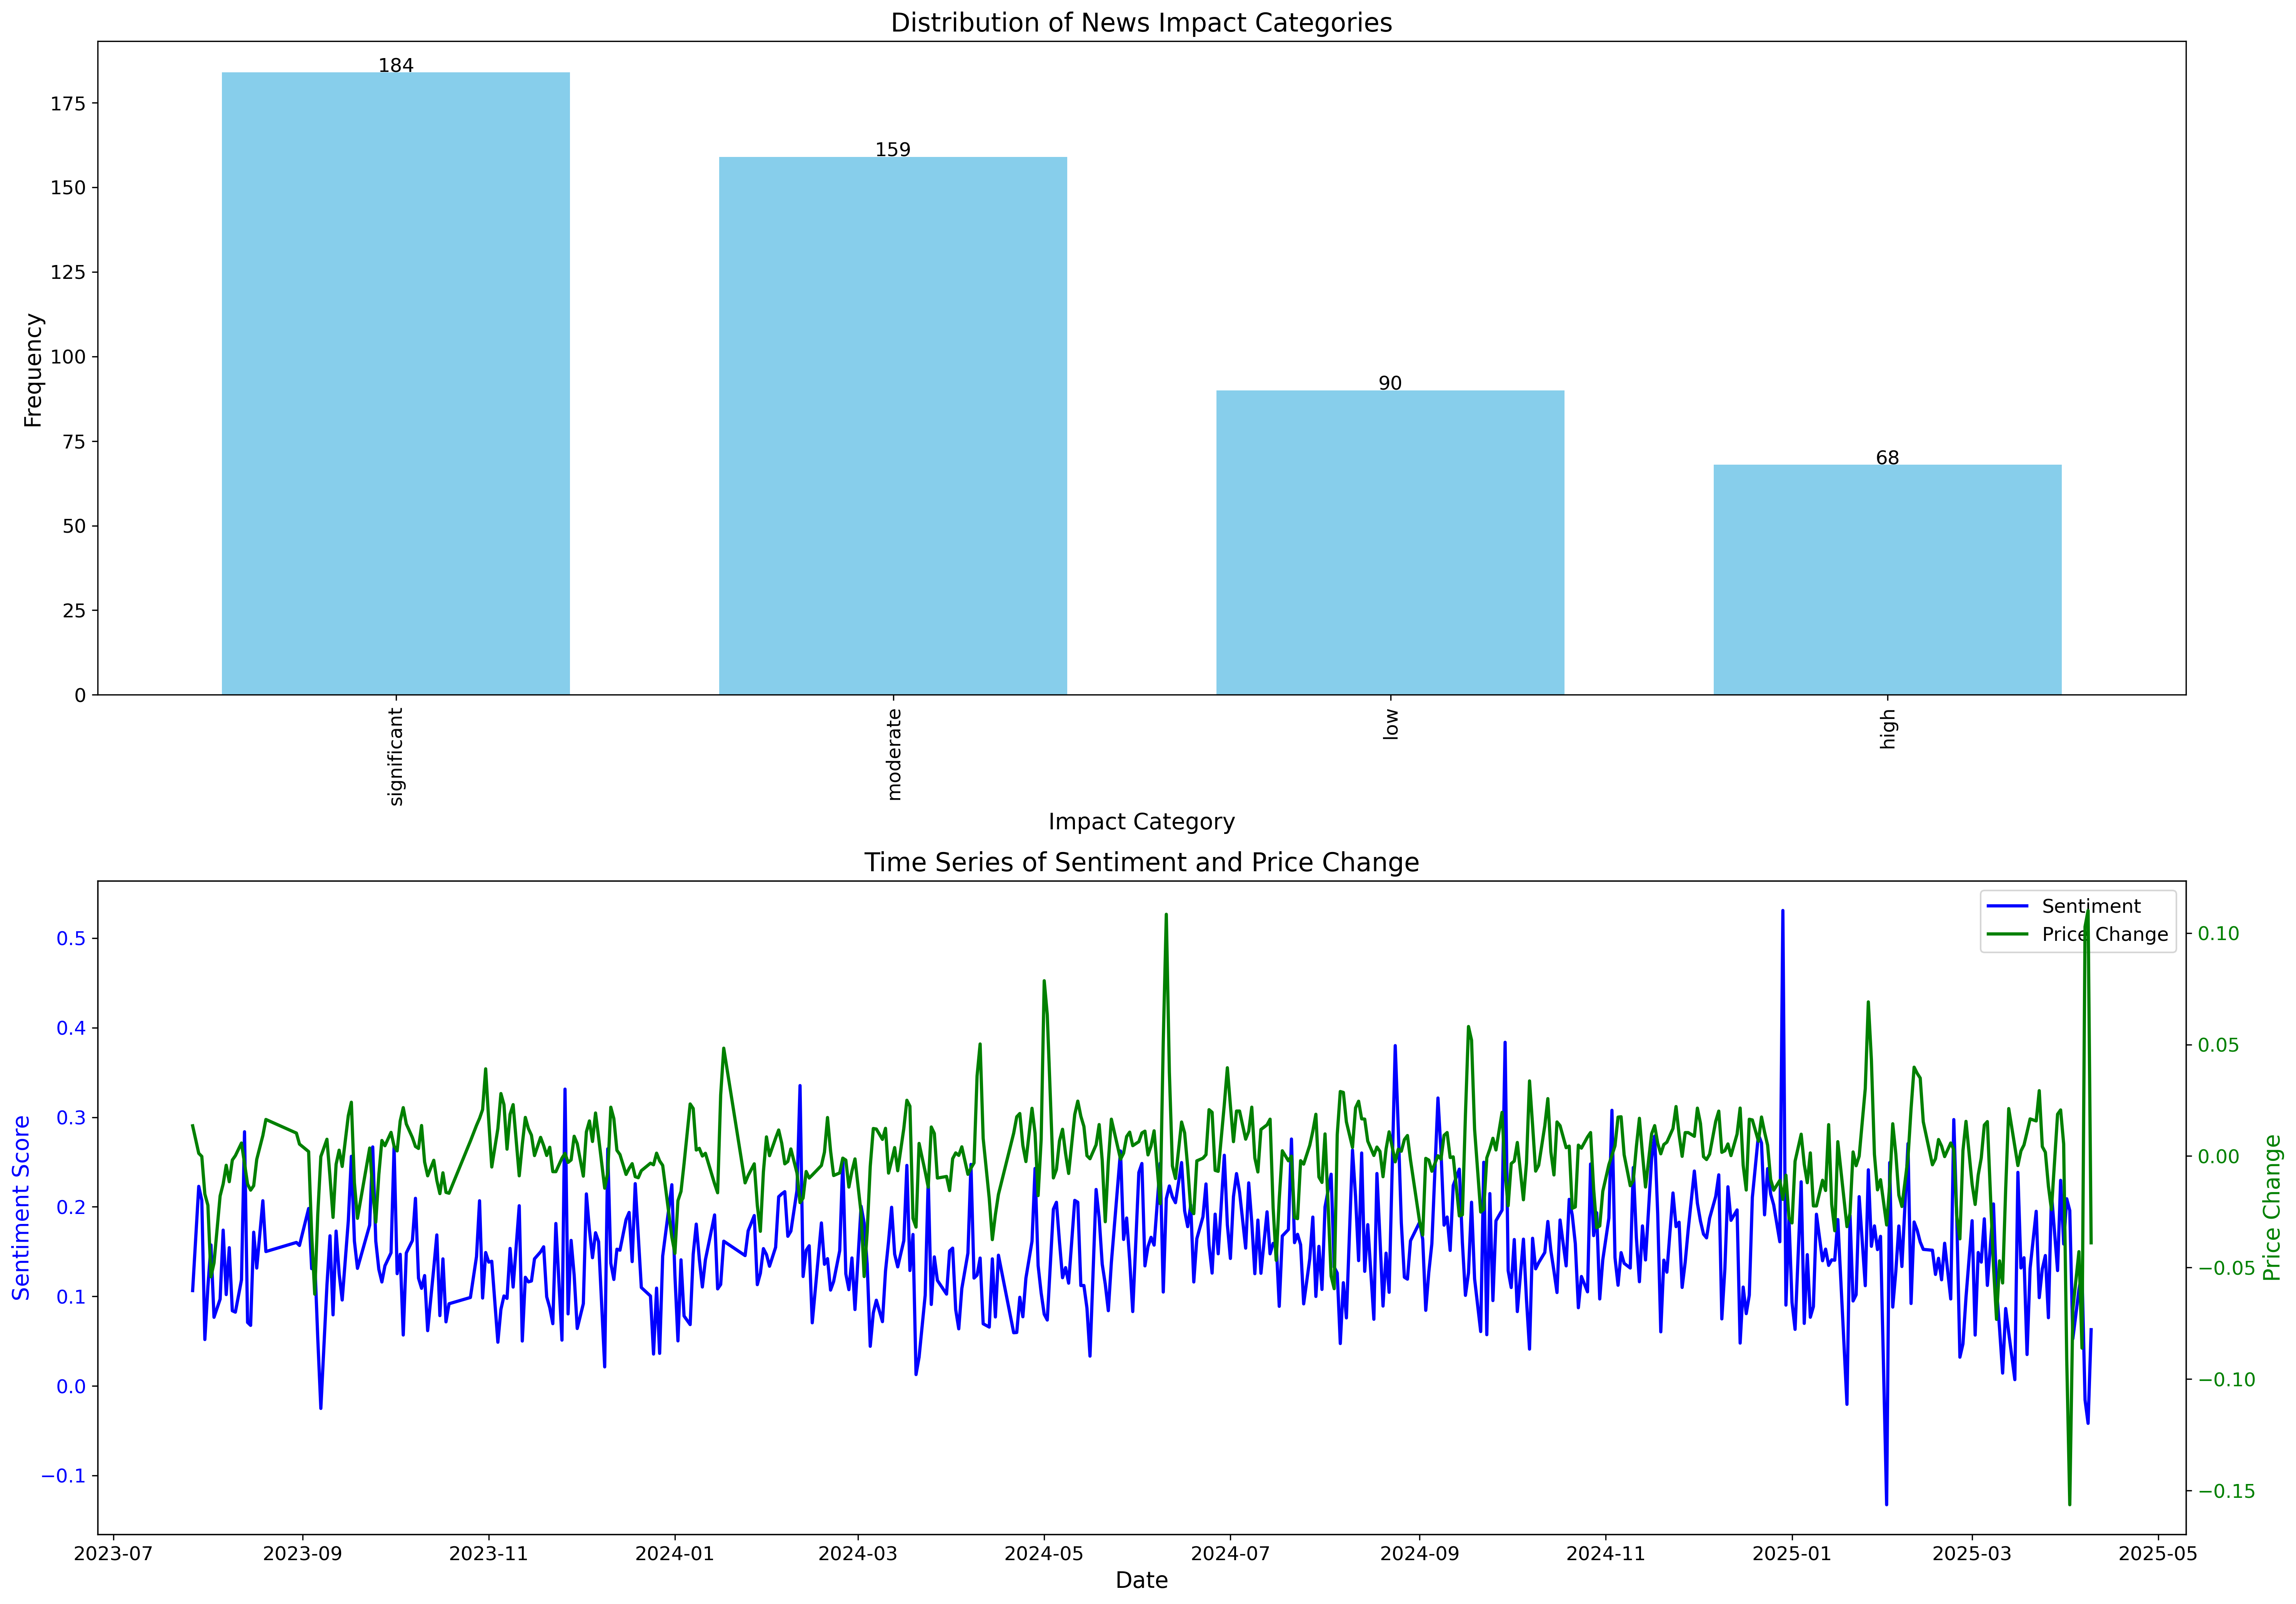

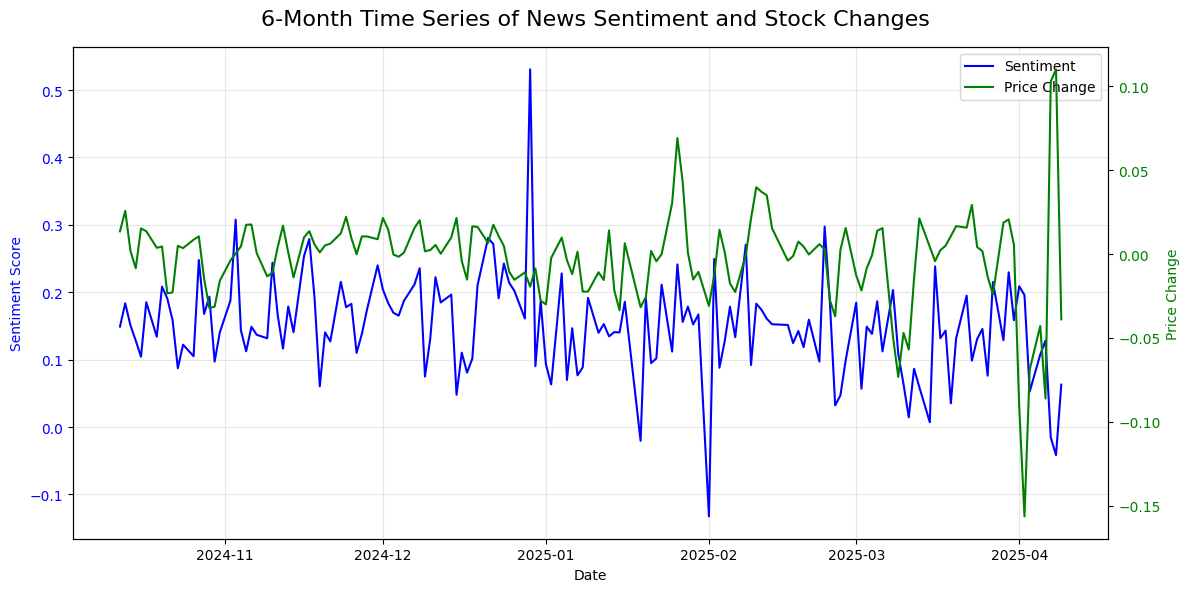

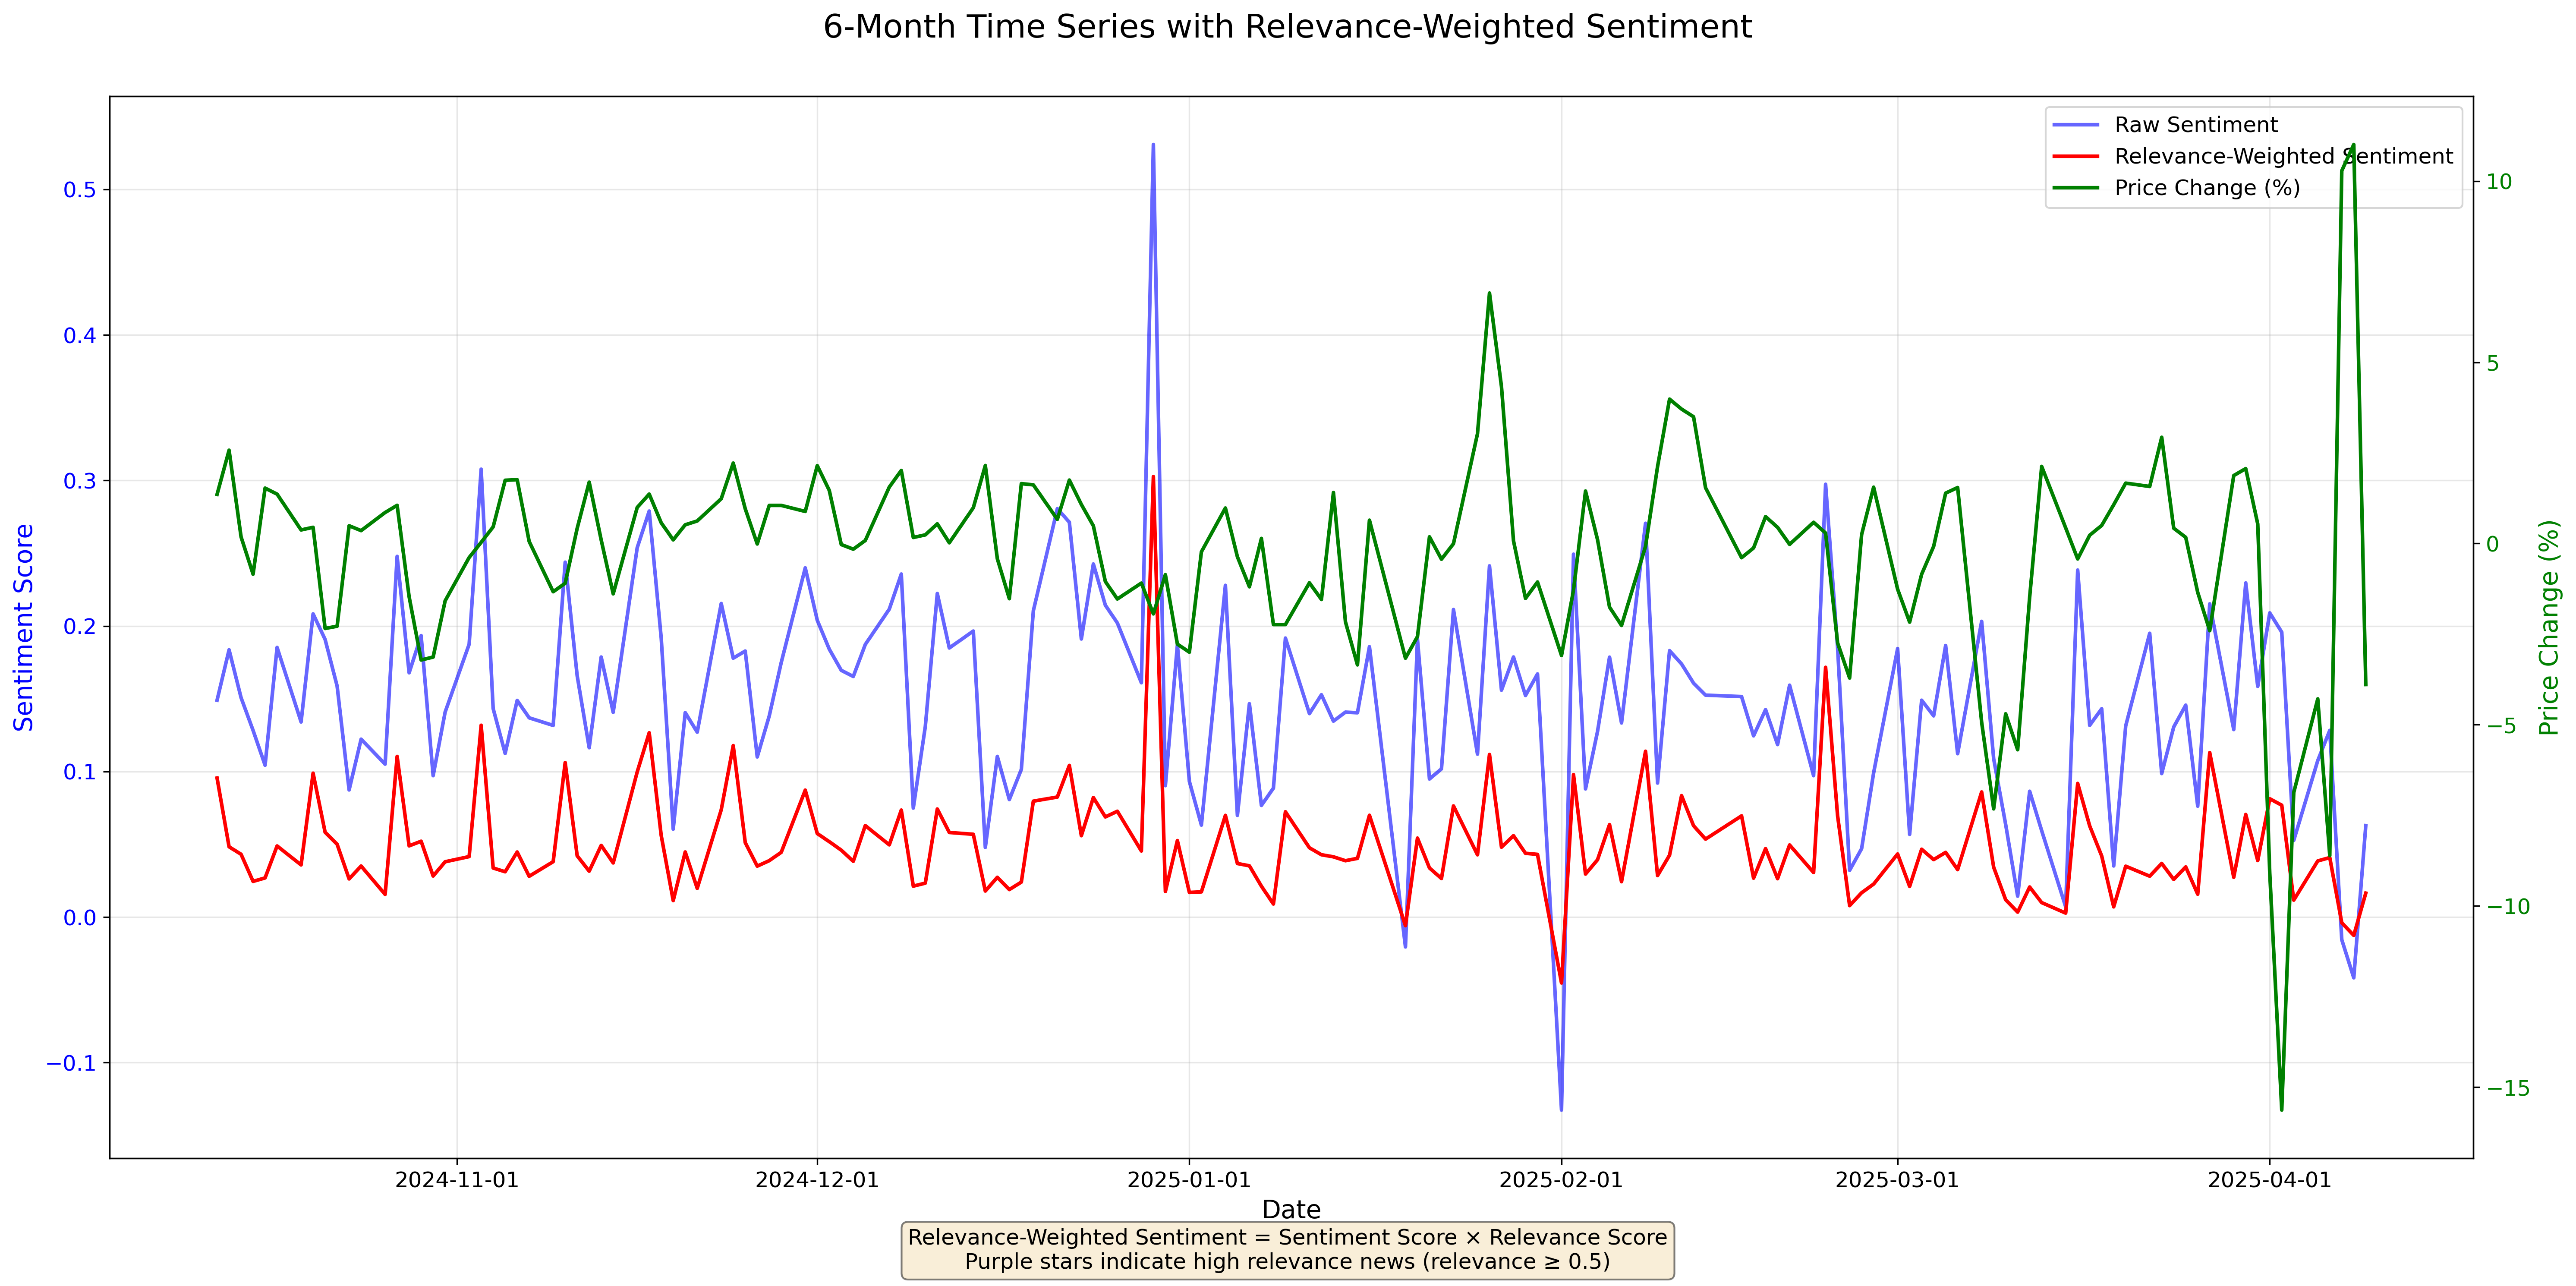

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, zscore
import matplotlib.pyplot as plt
from datetime import timedelta
import json
from Data.db import Database
import IPython.display as display
import matplotlib.dates as mdates

class NewsImpactAnalyzer:
    def __init__(self, database):
        self.db = database
        self.news_data = None
        self.stock_data = None

    def load_data(self, stock_id, timeframe=60, days_window=3):
        """
        Load news and stock data

        Parameters:
        - stock_id: ID of the stock to analyze
        - timeframe: Timeframe for stock data in minutes
        - days_window: Number of days to look ahead for stock price impact
        """
        # Load news data
        self.news_data = self.db.get_live_news_articles()

        # Filter news data for relevant ticker
        stock_symbol = self._get_stock_symbol(stock_id)
        self.news_data = self._filter_news_for_ticker(self.news_data, stock_symbol)

        # Load stock data
        self.stock_data = self.db.get_stock_data(stock_id, timeframe)

        # Ensure both datasets have data
        if self.news_data.empty or self.stock_data.empty:
            raise ValueError("Either news data or stock data is empty")

        print(f"Loaded {len(self.news_data)} news articles for {stock_symbol}")
        print(f"Loaded {len(self.stock_data)} stock price points")
        # Print the head and tail of the stock data for verification with the display function
        print(f"Stock Data Head: \n{self.stock_data.head()}")

        return self.news_data, self.stock_data

    def _get_stock_symbol(self, stock_id):
        """Get stock symbol from stock ID using a sample query"""
        sample = self.db.get_stock_data(stock_id, 60)
        if 'StockSymbol' in sample.columns:
            return sample['StockSymbol'].iloc[0]
        else:
            return f"Stock_{stock_id}"  # Fallback

    def _filter_news_for_ticker(self, news_df, ticker):
        """Filter news data to only include articles mentioning the ticker and extract ticker-specific sentiment"""
        filtered_news = pd.DataFrame()

        for _, row in news_df.iterrows():
            ticker_sentiment = row['Ticker_Sentiment']
            if ticker_sentiment:
                # Parse the ticker sentiment data
                if isinstance(ticker_sentiment, str):
                    try:
                        ticker_data = json.loads(ticker_sentiment)
                    except json.JSONDecodeError:
                        try:
                            ticker_data = ast.literal_eval(ticker_sentiment)
                        except (ValueError, SyntaxError):
                            continue
                elif isinstance(ticker_sentiment, list):
                    ticker_data = ticker_sentiment
                else:
                    continue

                # Look for the specific ticker
                for item in ticker_data:
                    if isinstance(item, dict) and item.get('ticker') == ticker:
                        # Create a new row with ticker-specific data
                        new_row = row.copy()
                        new_row['ticker_sentiment_score'] = float(item['ticker_sentiment_score'])
                        new_row['relevance_score'] = float(item['relevance_score'])
                        new_row['ticker_sentiment_label'] = item['ticker_sentiment_label']
                        filtered_news = pd.concat([filtered_news, pd.DataFrame([new_row])], ignore_index=True)
                        break
        return filtered_news
    
    def _create_weighted_sentiment(self, aligned_data):
        """Create relevance-weighted sentiment scores"""
        weighted_data = aligned_data.copy()
        weighted_data['weighted_sentiment'] = weighted_data['sentiment_score'] * weighted_data['relevance_score']
        return weighted_data
    
    def align_news_with_price_movements(self, impact_window=timedelta(days=2), min_articles=1):
        """
        Align news articles with subsequent stock price movements

        Parameters:
        - impact_window: Time window to look for price impact after news
        - min_articles: Minimum number of articles to consider a day newsworthy

        Returns:
        - DataFrame with news sentiment and subsequent price movements
        """
        # Ensure data is loaded
        if self.news_data is None or self.stock_data is None:
            raise ValueError("Data not loaded. Call load_data() first.")
        # Add diagnostic counts
        daily_news_before_filter = self.news_data.groupby(self.news_data['Date'].dt.date).size()
        print(f"Days with news before filtering: {len(daily_news_before_filter)}")
        
        # Group news by date and calculate average sentiment
        daily_news = self.news_data.groupby(self.news_data['Date'].dt.date).agg(
            {
            'ticker_sentiment_score': 'mean',
            'relevance_score': 'mean',
            'ID': 'count'  # Count articles per day
            }
        ).rename(columns={'ID': 'article_count'})

        # Filter days with minimum article count
        daily_news = daily_news[daily_news['article_count'] >= min_articles]
        print(f"Days with news after min_articles filter: {len(daily_news)}")
        
        # Calculate daily stock returns
        daily_stock = self.stock_data['ClosePrice'].resample('D').last()
        daily_stock = daily_stock.dropna()  # Remove NaN values (weekends/holidays)
        daily_stock_returns = daily_stock.pct_change(fill_method=None)

        # Initialize result dataframe
        result = []
        
        # For each news day, find subsequent price movements
        for news_date, news_row in daily_news.iterrows():
            news_date = pd.Timestamp(news_date)
            
            # Define the impact window
            start_date = news_date
            end_date = news_date + impact_window
            
            # Find stock returns in the impact window
            future_returns = daily_stock_returns[(daily_stock_returns.index > start_date) & 
                                               (daily_stock_returns.index <= end_date)]
            
            if not future_returns.empty:
                # Check if we have valid returns
                future_returns = future_returns.dropna()
                
                if len(future_returns) > 0:
                    # Calculate cumulative return in the impact window
                    cumulative_return = (1 + future_returns).prod() - 1
                    max_return = future_returns.max()
                    min_return = future_returns.min()
                    volatility = future_returns.std()
                    
                    result.append({
                        'news_date': news_date,
                        'sentiment_score': news_row['ticker_sentiment_score'],
                        'relevance_score': news_row['relevance_score'],
                        'article_count': news_row['article_count'],
                        'cumulative_return': cumulative_return,
                        'max_return': max_return,
                        'min_return': min_return,
                        'volatility': volatility
                    })
        # After matching with stock data and processing
        print(f"Final days with valid news and returns: {len(result)}")
            # Show date range
        if result:
            earliest_date = min(row['news_date'] for row in result)
            latest_date = max(row['news_date'] for row in result)
            print(f"Date range of processed data: {earliest_date} to {latest_date}")
        return pd.DataFrame(result)

    # def analyze_sentiment_price_correlation(self, aligned_data, method='both'):
    #     """
    #     Analyze correlation between news sentiment and price movements
    # 
    #     Parameters:
    #     - aligned_data: DataFrame from align_news_with_price_movements()
    #     - method: 'pearson', 'spearman', or 'both'
    # 
    #     Returns:
    #     - Dictionary with correlation coefficients and p-values
    #     """
    #     correlations = {}

        # # Calculate correlations for different metrics
        # for metric in ['cumulative_return', 'max_return', 'min_return', 'volatility']:
        #     if len(aligned_data) > 2:  # Need at least 3 points for correlation
        #         # Check for sufficient variance in the data
        #         if aligned_data[metric].nunique() > 1 and aligned_data['sentiment_score'].nunique() > 1:
        # 
        #             # Calculate Pearson correlation if requested
        #             if method in ['pearson', 'both']:
        #                 p_corr, p_value = pearsonr(aligned_data['sentiment_score'], aligned_data[metric])
        #                 correlations[f'pearson_{metric}'] = {'correlation': p_corr, 'p_value': p_value}
        # 
        #             # Calculate Spearman correlation if requested
        #             if method in ['spearman', 'both']:
        #                 s_corr, s_value = spearmanr(aligned_data['sentiment_score'], aligned_data[metric])
        #                 correlations[f'spearman_{metric}'] = {'correlation': s_corr, 'p_value': s_value}
        #         else:
        #             if method in ['pearson', 'both']:
        #                 correlations[f'pearson_{metric}'] = {'correlation': None, 'p_value': None, 'reason': 'insufficient_variance'}
        #             if method in ['spearman', 'both']:
        #                 correlations[f'spearman_{metric}'] = {'correlation': None, 'p_value': None, 'reason': 'insufficient_variance'}
        #     else:
        #         if method in ['pearson', 'both']:
        #             correlations[f'pearson_{metric}'] = {'correlation': None, 'p_value': None, 'reason': 'insufficient_data_points'}
        #         if method in ['spearman', 'both']:
        #             correlations[f'spearman_{metric}'] = {'correlation': None, 'p_value': None, 'reason': 'insufficient_data_points'}
        # 
        # return correlations

    def classify_impact(self, aligned_data, sentiment_thresholds=None, return_thresholds=None):
        """
        Classify news impact based on sentiment and price movement thresholds

        Parameters:
        - aligned_data: DataFrame from align_news_with_price_movements()
        - sentiment_thresholds: Not used, kept for compatibility
        - return_thresholds: Tuple of (weak/medium, medium/strong) thresholds for returns

        Returns:
        - DataFrame with impact classifications
        """
        # Set default thresholds if not provided
        if return_thresholds is None:
            # Calculate based on quantiles if we have enough data
            if len(aligned_data) >= 5:
                return_thresholds = (
                    aligned_data['cumulative_return'].quantile(0.33),
                    aligned_data['cumulative_return'].quantile(0.67)
                )
                print(f"Calculated return thresholds: {return_thresholds}")
            else:
                return_thresholds = (0.005, 0.015)  # Default values - 0.5% and 1.5%
                print("Using default return thresholds: ", return_thresholds)

        # Create a copy of the data
        impact_data = aligned_data.copy()

        # Classify sentiment using AlphaVantage ranges
        impact_data['sentiment_impact'] = 'neutral'
        impact_data.loc[impact_data['sentiment_score'] <= -0.35, 'sentiment_impact'] = 'bearish'
        impact_data.loc[(impact_data['sentiment_score'] > -0.35) & (impact_data['sentiment_score'] <= -0.15), 'sentiment_impact'] = 'somewhat-bearish'
        impact_data.loc[(impact_data['sentiment_score'] >= 0.15) & (impact_data['sentiment_score'] < 0.35), 'sentiment_impact'] = 'somewhat-bullish'
        impact_data.loc[impact_data['sentiment_score'] >= 0.35, 'sentiment_impact'] = 'bullish'

        # Map AlphaVantage sentiment categories to original three-level categories for compatibility
        # This ensures the rest of the code works with the new sentiment classifications
        sentiment_mapping = {
            'bearish': 'weak',
            'somewhat-bearish': 'weak',
            'neutral': 'medium',
            'somewhat-bullish': 'strong',
            'bullish': 'strong'
        }

        # Create a temporary column with mapped values for compatibility with existing logic
        impact_data['sentiment_impact_mapped'] = impact_data['sentiment_impact'].map(sentiment_mapping)

        # Classify returns (absolute value to capture both positive and negative moves)
        impact_data['price_impact'] = 'medium'
        impact_data.loc[abs(impact_data['cumulative_return']) <= return_thresholds[0], 'price_impact'] = 'weak'
        impact_data.loc[abs(impact_data['cumulative_return']) >= return_thresholds[1], 'price_impact'] = 'strong'

        # Classify direction
        impact_data['price_direction'] = 'neutral'
        impact_data.loc[impact_data['cumulative_return'] > 0, 'price_direction'] = 'positive'
        impact_data.loc[impact_data['cumulative_return'] < 0, 'price_direction'] = 'negative'

        # Overall impact (combine sentiment strength and price impact)
        # Use the mapped sentiment values for compatibility with existing impact logic
        impact_data['overall_impact'] = 'negligible'

        # Define a mapping for impact levels (using mapped sentiment values)
        impact_mapping = {
            ('weak', 'weak'): 'negligible',
            ('weak', 'medium'): 'low',
            ('weak', 'strong'): 'moderate',
            ('medium', 'weak'): 'low',
            ('medium', 'medium'): 'moderate',
            ('medium', 'strong'): 'significant',
            ('strong', 'weak'): 'moderate',
            ('strong', 'medium'): 'significant',
            ('strong', 'strong'): 'high'
        }

        # Apply the mapping using the mapped sentiment values
        for sentiment, price in impact_mapping.keys():
            mask = (impact_data['sentiment_impact_mapped'] == sentiment) & (impact_data['price_impact'] == price)
            impact_data.loc[mask, 'overall_impact'] = impact_mapping[(sentiment, price)]

        # Drop the temporary mapping column as it's no longer needed
        impact_data.drop('sentiment_impact_mapped', axis=1, inplace=True)

        return impact_data

    def _create_six_month_time_series(self, impact_data):
        """
        Create a separate time series specifically for a 6-month period

        Parameters:
        - impact_data: DataFrame from classify_impact()

        Returns:
        - Matplotlib figure for 6-month time series
        """
        if len(impact_data) < 3:
            print("Not enough data points for 6-month visualization")
            return None

        # Sort by date
        time_data = impact_data.sort_values('news_date')

        # If we have enough data, use the most recent 6 months
        # Otherwise, use all available data and note in the title
        newest_date = time_data['news_date'].max()
        six_months_ago = newest_date - pd.Timedelta(days=180)

        six_month_data = time_data[time_data['news_date'] >= six_months_ago]

        # Create the figure
        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax2 = ax1.twinx()

        # Plot sentiment on primary y-axis
        ax1.plot(six_month_data['news_date'], six_month_data['sentiment_score'], 'b-', label='Sentiment')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Sentiment Score', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        # Plot returns on secondary y-axis
        ax2.plot(six_month_data['news_date'], six_month_data['cumulative_return'], 'g-', label='Price Change')
        ax2.set_ylabel('Price Change', color='g')
        ax2.tick_params(axis='y', labelcolor='g')

        # Add a grid for better readability
        ax1.grid(True, alpha=0.3)

        # Create combined legend
        sentiment_line = ax1.lines[0]
        return_line = ax2.lines[0]
        ax1.legend([sentiment_line, return_line], ['Sentiment', 'Price Change'], loc='best')

        # Set title that indicates the time period
        period_text = "6-Month" if len(six_month_data) > 3 else "Available Data (Less than 6 Months)"
        fig.suptitle(f'{period_text} Time Series of News Sentiment and Stock Changes', fontsize=16)

        plt.tight_layout()
        return fig
    def _create_relevance_weighted_time_series(self, impact_data):
        """
        Create a 6-month time series that visualizes sentiment weighted by relevance
        
        Parameters:
        - impact_data: DataFrame from classify_impact()
        
        Returns:
        - Matplotlib figure for 6-month relevance-weighted time series
        """
        if len(impact_data) < 3:
            print("Not enough data points for relevance-weighted visualization")
            return None
            
        # Sort by date
        time_data = impact_data.sort_values('news_date')
        
        # Calculate relevance-weighted sentiment
        time_data['weighted_sentiment'] = time_data['sentiment_score'] * time_data['relevance_score']
        
        # Get the most recent 6 months of data
        newest_date = time_data['news_date'].max()
        six_months_ago = newest_date - pd.Timedelta(days=180)
        six_month_data = time_data[time_data['news_date'] >= six_months_ago]
        
        # Create the figure with higher resolution
        fig, ax1 = plt.subplots(figsize=(20, 10), dpi=300)
        ax2 = ax1.twinx()
        
        # Plot both raw and weighted sentiment on primary y-axis
        ax1.plot(six_month_data['news_date'], six_month_data['sentiment_score'], 'b-', 
                 label='Raw Sentiment', linewidth=2, alpha=0.6)
        ax1.plot(six_month_data['news_date'], six_month_data['weighted_sentiment'], 'r-', 
                 label='Relevance-Weighted Sentiment', linewidth=2)
        
        # Add markers for high-relevance points
        # high_relevance = six_month_data[six_month_data['relevance_score'] >= 0.6]
        # if not high_relevance.empty:
        #     ax1.scatter(high_relevance['news_date'], high_relevance['weighted_sentiment'], 
        #                 color='purple', s=150, zorder=5, 
        #                 label='High Relevance News', marker='*')
        
        ax1.set_xlabel('Date', fontsize=14)
        ax1.set_ylabel('Sentiment Score', color='b', fontsize=14)
        ax1.tick_params(axis='y', labelcolor='b', labelsize=12)
        ax1.tick_params(axis='x', labelsize=12)
        
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        
        # Plot price changes on secondary y-axis
        ax2.plot(six_month_data['news_date'], six_month_data['cumulative_return']*100, 'g-', 
                 label='Price Change (%)', linewidth=2)
        ax2.set_ylabel('Price Change (%)', color='g', fontsize=14)
        ax2.tick_params(axis='y', labelcolor='g', labelsize=12)
        
        # Add grid for better readability
        ax1.grid(True, alpha=0.3)
        
        # Create combined legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=12)
        
        # Add title
        period_text = "6-Month" if len(six_month_data) > 3 else "Available Data (Less than 6 Months)"
        fig.suptitle(f'{period_text} Time Series with Relevance-Weighted Sentiment', fontsize=18)
        
        # Add an annotation explaining the weighted sentiment
        plt.figtext(0.5, 0.01, 
                    "Relevance-Weighted Sentiment = Sentiment Score × Relevance Score\n" +
                    "Purple stars indicate high relevance news (relevance ≥ 0.5)",
                    ha='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for annotation
        return fig
    
    def visualize_impact(self, impact_data, start_date=None, end_date=None):
        """
        Create visualizations for news sentiment impact on stock prices
        """
        if len(impact_data) < 3:
            print("Not enough data points for meaningful visualization")
            return None, None
            
        # Filter data based on date range if provided
        if start_date and end_date:
            impact_data = impact_data[(impact_data['news_date'] >= start_date) & 
                                    (impact_data['news_date'] <= end_date)]
        else:
            impact_data = impact_data
            
        # Increase figure size for higher resolution
        fig, axs = plt.subplots(2, 1, figsize=(20, 14), dpi=300)  # Increased size and dpi
    
        # Bar chart of overall impact distribution
        impact_counts = impact_data['overall_impact'].value_counts()
        impact_counts.plot(kind='bar', ax=axs[0], color='skyblue', width=0.7)
        axs[0].set_xlabel('Impact Category', fontsize=14)
        axs[0].set_ylabel('Frequency', fontsize=14)
        axs[0].set_title('Distribution of News Impact Categories', fontsize=16)
        axs[0].tick_params(axis='both', which='major', labelsize=12)
        
        # Add value labels on top of bars
        for i, v in enumerate(impact_counts):
            axs[0].text(i, v + 0.1, str(v), ha='center', fontsize=12)
    
        # Time series of sentiment and returns
        ax1 = axs[1]
        ax2 = ax1.twinx()
    
        # Sort by date for time series
        time_data = impact_data.sort_values('news_date')
    
        ax1.plot(time_data['news_date'], time_data['sentiment_score'], 'b-', label='Sentiment', linewidth=2)
        ax1.set_xlabel('Date', fontsize=14)
        ax1.set_ylabel('Sentiment Score', color='b', fontsize=14)
        ax1.tick_params(axis='y', labelcolor='b', labelsize=12)
        ax1.tick_params(axis='x', labelsize=12)
    
        ax2.plot(time_data['news_date'], time_data['cumulative_return'], 'g-', label='Price Change', linewidth=2)
        ax2.set_ylabel('Price Change', color='g', fontsize=14)
        ax2.tick_params(axis='y', labelcolor='g', labelsize=12)
    
        axs[1].set_title('Time Series of Sentiment and Price Change', fontsize=16)
    
        # Create a legend for the third plot
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=12)
    
        plt.tight_layout()
    
        # Also update the six-month visualization to match the higher resolution
        six_month_fig = self._create_six_month_time_series(impact_data)
    
        return fig, six_month_fig

    def run_full_analysis(self, stock_id, timeframe=60, impact_window_days=2, 
                          sentiment_thresholds=None, return_thresholds=None,
                          start_date=None, end_date=None):
        """
        Run the complete news impact analysis pipeline

        Parameters:
        - stock_id: ID of the stock to analyze
        - timeframe: Timeframe for stock data in minutes
        - impact_window_days: Number of days to look ahead for stock price impact
        - sentiment_thresholds: Tuple of (weak/medium, medium/strong) thresholds for sentiment
        - return_thresholds: Tuple of (weak/medium, medium/strong) thresholds for returns
    - start_date: Optional start date for analysis (format: 'YYYY-MM-DD')
    - end_date: Optional end date for analysis (format: 'YYYY-MM-DD')
        Returns:
        - Dictionary with analysis results
        """
        # Load data
        self.load_data(stock_id, timeframe)

        print(f"Timedelta = {timedelta(days=impact_window_days)} days")
        
        # Align news with price movements
        aligned_data = self.align_news_with_price_movements(
            impact_window=timedelta(days=impact_window_days)
        )
        
        # Filter data by date if specified
        if start_date or end_date:
            # Convert string dates to pandas timestamps if provided
            pd_start_date = pd.Timestamp(start_date) if start_date else None
            pd_end_date = pd.Timestamp(end_date) if end_date else None
            
            # Filter aligned data
            if pd_start_date and pd_end_date:
                print(f"Filtering data from {pd_start_date.date()} to {pd_end_date.date()}")
                aligned_data = aligned_data[(aligned_data['news_date'] >= pd_start_date) & 
                                         (aligned_data['news_date'] <= pd_end_date)]
            elif pd_start_date:
                print(f"Filtering data from {pd_start_date.date()} onwards")
                aligned_data = aligned_data[aligned_data['news_date'] >= pd_start_date]
            elif pd_end_date:
                print(f"Filtering data up to {pd_end_date.date()}")
                aligned_data = aligned_data[aligned_data['news_date'] <= pd_end_date]
                
            print(f"After date filtering: {len(aligned_data)} data points")
        
        # Apply relevance weighting to sentiment
        weighted_data = self._create_weighted_sentiment(aligned_data)

        # Check if aligned data is not loading properly
        if len(aligned_data) < 3:
            print(f"Warning: Only {len(aligned_data)} data points available for analysis.")
            if len(aligned_data) == 0:
                return {
                    "error": "No aligned data points found",
                    "stock_id": stock_id,
                    "aligned_data": aligned_data
                }

        # Analyze correlation
        # correlations = {}
        # correlations['original'] = self.analyze_sentiment_price_correlation(aligned_data, method='both')
        # correlations['weighted'] = self.analyze_sentiment_price_correlation_enhanced(weighted_data, 'weighted_sentiment', method='both')
        
        # Filter by relevance for high-relevance news
        high_relevance_data = aligned_data[aligned_data['relevance_score'] >= 0.5]
        # if len(high_relevance_data) > 3:
        #     correlations['high_relevance'] = self.analyze_sentiment_price_correlation(high_relevance_data, method='both')

        # Classify impact
        impact_data = self.classify_impact(
            aligned_data, 
            sentiment_thresholds=sentiment_thresholds,
            return_thresholds=return_thresholds
        )

        # Visualize (optional)
        # fig = self.visualize_impact(impact_data) if len(impact_data) >= 3 else None
        fig, six_month_fig = self.visualize_impact(impact_data) if len(impact_data) >= 3 else (None, None)
        # Relevance-weighted time series
        relevance_weighted_fig = self._create_relevance_weighted_time_series(impact_data) if len(impact_data) >= 3 else None
        
        # Return results
        return {
            "aligned_data": aligned_data,
            "weighted_data": weighted_data,
            "high_relevance_data": high_relevance_data if len(high_relevance_data) > 0 else None,
            # "correlations": correlations,
            "impact_data": impact_data,
            "visualization": fig,
            "six_month_visualization": six_month_fig, # Added for 6-month visualization
            "relevance_weighted_visualization": relevance_weighted_fig,  # The new visualization
            "sentiment_thresholds": sentiment_thresholds,
            "return_thresholds": return_thresholds
        }
    # Add this method to support weighted sentiment analysis
    # def analyze_sentiment_price_correlation_enhanced(self, data, sentiment_column, method='both'):
    #     """Analyze correlation with alternative sentiment metrics"""
    #     correlations = {}
    #     
    #     # Calculate correlations for different metrics
    #     for metric in ['cumulative_return', 'max_return', 'min_return', 'volatility']:
    #         if len(data) > 2 and sentiment_column in data.columns:
    #             # Check for sufficient variance
    #             if data[metric].dropna().nunique() > 1 and data[sentiment_column].dropna().nunique() > 1:
    #                 # Calculate Pearson correlation if requested
    #                 if method in ['pearson', 'both']:
    #                     p_corr, p_value = pearsonr(data[sentiment_column], data[metric])
    #                     correlations[f'pearson_{metric}'] = {'correlation': p_corr, 'p_value': p_value}
    #                 
    #                 # Calculate Spearman correlation if requested
    #                 if method in ['spearman', 'both']:
    #                     s_corr, s_value = spearmanr(data[sentiment_column], data[metric])
    #                     correlations[f'spearman_{metric}'] = {'correlation': s_corr, 'p_value': s_value}
    #             else:
    #                 # Handle insufficient variance
    #                 correlations[f'pearson_{metric}'] = {'correlation': None, 'p_value': None, 'reason': 'insufficient_variance'}
    #                 correlations[f'spearman_{metric}'] = {'correlation': None, 'p_value': None, 'reason': 'insufficient_variance'}
    #         else:
    #             # Handle insufficient data
    #             correlations[f'pearson_{metric}'] = {'correlation': None, 'p_value': None, 'reason': 'insufficient_data_points'}
    #             correlations[f'spearman_{metric}'] = {'correlation': None, 'p_value': None, 'reason': 'insufficient_data_points'}
    #     
    #     return correlations
    
# Example usage
def run_news_impact_analysis(start_date=None, end_date=None, specific_date=None, stock_id=3, timeframe=15, impact_window_days=2):
    from Data.db import Database
    db = Database()

    analyzer = NewsImpactAnalyzer(db)
    
    # If we have a specified date, start and end dates will be the same
    if specific_date:
        start_date = specific_date
        end_date = specific_date
        print(f"Analyzing data for the date: {specific_date}")
    # The following to find the best threshold for the returns (Price Change)    
    analyzer.load_data(stock_id=stock_id, timeframe=timeframe) 

    # Get aligned data
    aligned_data = analyzer.align_news_with_price_movements(
        impact_window=timedelta(days=impact_window_days)
    )

    # Calculate absolute returns to focus on magnitude
    abs_returns = aligned_data['cumulative_return'].abs()

    # Calculate different potential thresholds
    percentile_thresholds = (
        abs_returns.quantile(0.33),
        abs_returns.quantile(0.67)
    )

    mean_std_thresholds = (
        max(0.001, abs_returns.mean() - 0.5 * abs_returns.std()),
        abs_returns.mean() + 1.0 * abs_returns.std()
    )

    # Try a few fixed values
    fixed_thresholds = [(0.005, 0.015), (0.01, 0.03), (0.02, 0.05)]

    # print("Candidate return thresholds:")
    print(f"Percentile-based (33/67): {percentile_thresholds}")
    # print(f"Mean/Std-based: {mean_std_thresholds}")
    # print(f"Fixed options: {fixed_thresholds}")
    
    # Run analysis for AAPL (assuming stock_id = 3)
    results = analyzer.run_full_analysis(
        stock_id=stock_id,               # AAPL
        timeframe=timeframe,             # 1-hour data
        impact_window_days=impact_window_days,     # Look 1 day ahead for price impact
        # sentiment_thresholds=(0.2, 0.6),  # Custom sentiment thresholds
        sentiment_thresholds=(-0.15, 0.15, 0.35), # AlphaVantage's sentiment thresholds
        return_thresholds=percentile_thresholds,  # 0.5% and 1.5% return thresholds
        start_date=start_date,
        end_date=end_date
    )
    
    # In run_news_impact_analysis, add this code after the original correlation display
    # if 'correlations' in results and 'weighted' in results['correlations']:
    #     print("\nRelevance-Weighted Sentiment Correlations:")
    #     weighted_results = results['correlations']['weighted']
    #     
    #     print("Pearson Correlations:")
    #     for metric, values in {k:v for k,v in weighted_results.items() if k.startswith('pearson_')}.items():
    #         metric_name = metric.replace('pearson_', '')
    #         corr = values.get('correlation')
    #         p_val = values.get('p_value')
    #         
    #         if corr is not None and p_val is not None:
    #             print(f"{metric_name}: correlation = {corr:.4f}, p-value = {p_val:.4f}")
    #         else:
    #             reason = values.get('reason', 'unknown')
    #             print(f"{metric_name}: correlation = {corr}, p-value = {p_val} ({reason})")
    
    # Display example of classified impact
    if 'impact_data' in results and not results['impact_data'].empty:
        print("\n==================== Head =====================")
        print("\nSample of classified impact:")
        sample = results['impact_data'].head(7)
        for _, row in sample.iterrows():
            print(f"Date: {row['news_date'].strftime('%Y-%m-%d')}")
            print(f"  Sentiment: {row['sentiment_score']:.4f} ({row['sentiment_impact']})")
            print(f"  Price change: {row['cumulative_return']*100:.2f}% ({row['price_impact']}, {row['price_direction']})")
            print(f"  Overall impact: {row['overall_impact']}")
            print()
    
    # Display example of classified impact
    if 'impact_data' in results and not results['impact_data'].empty:
        print("\n==================== Tail =====================")
        print("\nSample of classified impact:")
        sample = results['impact_data'].tail(7)
        for _, row in sample.iterrows():
            print(f"Date: {row['news_date'].strftime('%Y-%m-%d')}")
            print(f"  Sentiment: {row['sentiment_score']:.4f} ({row['sentiment_impact']})")
            print(f"  Price change: {row['cumulative_return']*100:.2f}% ({row['price_impact']}, {row['price_direction']})")
            print(f"  Overall impact: {row['overall_impact']}")
            print()
        # Then, we will print these data using the display module
        # display.display(sample)
    
    # Display the total number of articles
    if 'impact_data' in results and not results['impact_data'].empty:
        total_articles = results['impact_data']['article_count'].sum()
        print(f"\nTotal number of articles considered: {total_articles}")
    
    # Show the visualization if available
    if 'visualization' in results and results['visualization'] is not None:
        plt.show()
    # Display the six-month visualization
    if 'six_month_visualization' in results and results['six_month_visualization'] is not None:
        plt.figure(results['six_month_visualization'].number)
        plt.show()
    
    # Display the relevance-weighted time series visualization
    if 'relevance_weighted_visualization' in results and results['relevance_weighted_visualization'] is not None:
        plt.figure(results['relevance_weighted_visualization'].number)
        plt.show()
                
    return results


if __name__ == "__main__":
    # results = run_news_impact_analysis()
    start_date = None
    end_date = None
    specific_date = "2024-03-01"
    stock_id = 3
    timeframe = 15
    impact_window_days = 2
    result = run_news_impact_analysis(
        # specific_date=specific_date,
        stock_id=stock_id,
        timeframe=timeframe,
        impact_window_days=impact_window_days
    )